# # Análise Exploratória

In [1]:
import librosa
import librosa.display

import numpy as np
import pandas as pd
import seaborn as sns
import IPython.display as ipd
import matplotlib.pyplot as plt

from random import choice

%matplotlib inline

In [2]:
ARQUIVO_XFUSAO = 'DATAFRAMES/Xfusao.csv'

In [3]:
Xfusao = pd.read_csv(ARQUIVO_XFUSAO, sep=';')
Xfusao.shape

(1364, 8)

In [4]:
Xfusao.head()

,path,dataset,arquivo,pessoa,genero,emocao,intensidade,duracao
0,/media/hbrandao/STORAGE_HDD_1TB/PPGI/VERBO/Aud...,verbo,ale-f1-l1.wav,f1,f,alegria,NaN,2.451610
1,/media/hbrandao/STORAGE_HDD_1TB/PPGI/VERBO/Aud...,verbo,ale-f1-l2.wav,f1,f,alegria,NaN,3.916553
2,/media/hbrandao/STORAGE_HDD_1TB/PPGI/VERBO/Aud...,verbo,ale-f1-l3.wav,f1,f,alegria,NaN,3.482993
3,/media/hbrandao/STORAGE_HDD_1TB/PPGI/VERBO/Aud...,verbo,ale-f1-l4.wav,f1,f,alegria,NaN,3.684354
4,/media/hbrandao/STORAGE_HDD_1TB/PPGI/VERBO/Aud...,verbo,ale-f1-l5.wav,f1,f,alegria,NaN,2.343061


## Representação do som

## Sinal

In [5]:
p = choice(Xfusao['path'])
f = p.split('/')[-1]

p, f

('/media/hbrandao/STORAGE_HDD_1TB/PPGI/VIVAE/VIVAE/full_set/S04_surprise_moderate_07.wav',
 'S04_surprise_moderate_07.wav')

In [6]:
sinal, sr = librosa.load(p, sr=None)
duracao = librosa.get_duration(y=sinal, sr=sr)

print(f'sinal.shape = {sinal.shape}, sr = {sr}, duracao = {duracao:.2f}s')

sinal.shape = (48145,), sr = 44100, duracao = 1.09s


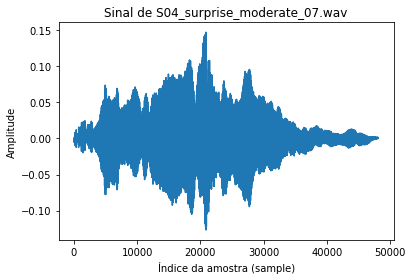

In [7]:
plt.plot(sinal);

plt.title(f'Sinal de {f}');
plt.xlabel('Índice da amostra (sample)');
plt.ylabel('Amplitude');

plt.show()

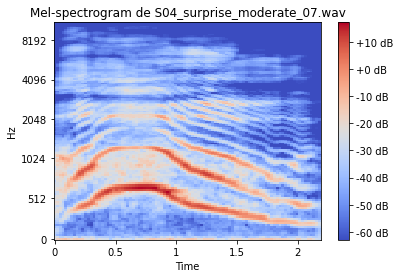

In [8]:
melspec = librosa.feature.melspectrogram(y=sinal, sr=sr)
melspec = librosa.power_to_db(melspec)

img = librosa.display.specshow(melspec, x_axis='time', y_axis='mel')
plt.colorbar(format='%+2.0f dB')

plt.title(f'Mel-spectrogram de {f}')

plt.show()

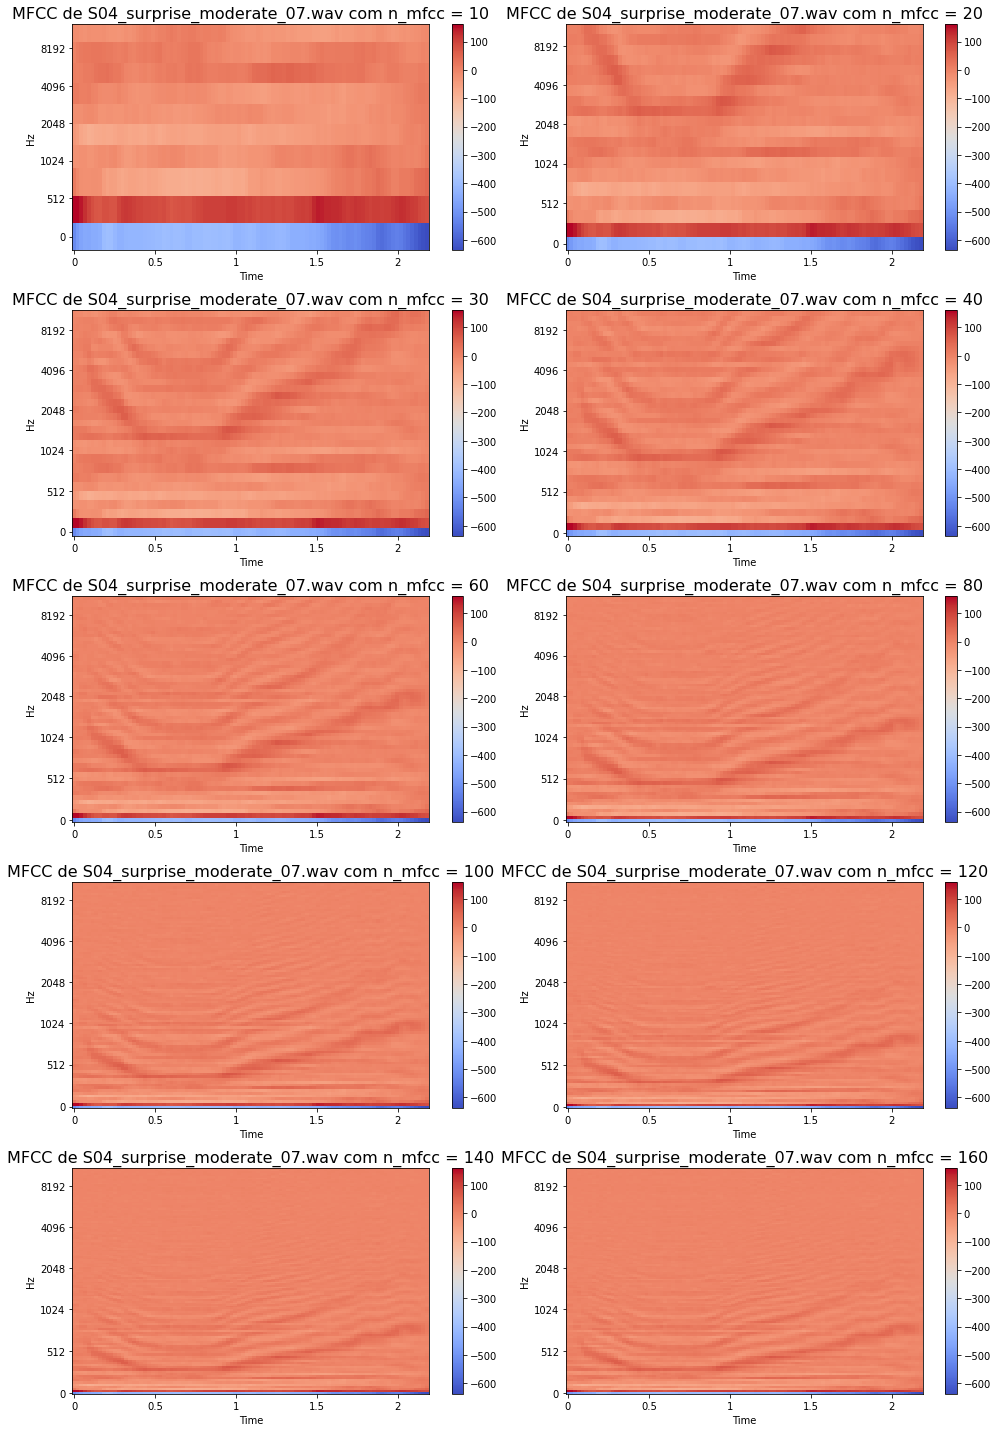

In [9]:
plt.figure(figsize=(14,20))

row, col, idx = 5, 2, 1

for n in (10, 20, 30, 40, 60, 80, 100, 120, 140, 160):
    plt.subplot(row, col, idx)
    melceps = librosa.feature.mfcc(y=sinal, sr=sr, n_mfcc=n)
    librosa.display.specshow(melceps, x_axis='time', y_axis='mel')
    plt.title(f'MFCC de {f} com n_mfcc = {n}', fontsize=16)
    plt.colorbar()
    idx += 1

plt.tight_layout()
plt.show()

Vamos verificar o _sampling rate_ dos arquivos:

In [10]:
__ = [librosa.load(_, sr=None)[-1] for _ in Xfusao['path']]

In [11]:
pd.Series(data=__).describe()

count     1364.000000
mean     43476.466276
std       5727.329199
min      16000.000000
25%      44100.000000
50%      44100.000000
75%      44100.000000
max      48000.000000
dtype: float64

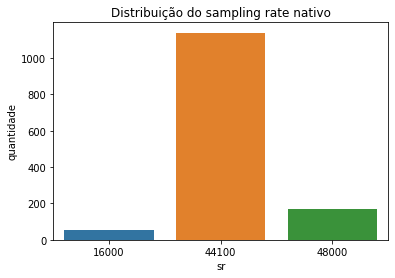

In [12]:
___ = pd.Series(data=__).value_counts()

sns.barplot(x=___.index, y=___.values)
plt.xlabel('sr')
plt.ylabel('quantidade')
plt.title('Distribuição do sampling rate nativo')

plt.show()

Assim, a partir de agora iremos assumir o $sr = 44100$ para carregar os arquivos

In [13]:
SAMPLING_RATE = 44100

## MFCC

In [14]:
NUM_MFCCS = 120

In [15]:
%%time

Xfusao_mfcc = [
    librosa.feature.mfcc(y=librosa.load(path=_, sr=SAMPLING_RATE)[0],
                         sr=SAMPLING_RATE,
                         n_mfcc=NUM_MFCCS)
    for _ in Xfusao['path']
]

CPU times: user 1min 13s, sys: 2min 30s, total: 3min 43s
Wall time: 19.9 s


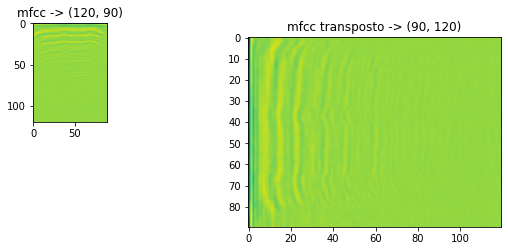

In [16]:
plt.figure(figsize=(10,4))

idx = 777

plt.subplot(2,2,1)
_ = Xfusao_mfcc[idx]
plt.imshow(_)
plt.title(f'mfcc -> {_.shape}')

plt.subplot(1,2,2)
_ = Xfusao_mfcc[idx].T
plt.imshow(_)
plt.title(f'mfcc transposto -> {_.shape}')

plt.show()

In [17]:
Xfusao_mfcc_mean = [np.mean(_.T, axis=0) for _ in Xfusao_mfcc]  # tomando mfcc.T

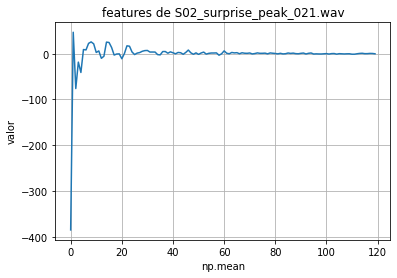

In [19]:
a = Xfusao['arquivo'].iloc[777]

plt.plot(Xfusao_mfcc_mean[777])

plt.title(f'features de {a}')
plt.xlabel('np.mean')
plt.ylabel('valor')
plt.grid()
plt.show()

In [20]:
Xfusao_mfcc_mean = pd.DataFrame(data=Xfusao_mfcc_mean)
Xfusao_mfcc_mean.shape

(1364, 120)

In [21]:
Xfusao_mfcc_mean.head()

,0,1,2,3,4,5,6,7,8,9,...,110,111,112,113,114,115,116,117,118,119
0,-264.792786,125.539139,-62.624714,28.315695,1.279387,-8.616631,-4.265706,12.050941,-27.621435,-7.861643,...,-1.748398,-0.898110,-0.119338,0.555444,0.690031,0.893465,0.846773,0.283752,-0.185898,-0.130898
1,-272.888550,121.097145,-41.149326,36.463421,7.565406,-16.098637,-6.408170,3.941464,-18.141294,-10.447558,...,-1.295892,-0.857775,-0.163954,0.522544,0.864576,0.903463,0.971885,0.158906,0.127875,0.256920
2,-252.119629,140.533325,-48.734734,25.311930,11.052135,-15.032625,-15.175117,-0.740196,-12.050269,-6.450643,...,-1.269958,-0.506434,0.136597,0.658416,1.204028,1.187821,1.145636,0.580611,0.591504,0.303071
3,-301.812012,115.630440,-44.689743,40.499535,12.119360,-9.788790,-14.219805,6.883999,-16.215971,-5.742364,...,-1.433162,-0.537758,-0.466619,0.289152,0.665391,0.794946,0.723460,1.131353,0.772526,-0.120861
4,-256.258118,118.041618,-61.199539,42.643768,14.546075,-13.713741,-13.657145,7.992791,-25.783739,-8.232481,...,-0.783558,-0.262848,-0.175987,0.290252,0.595873,1.549510,1.445828,0.597592,0.366670,0.384863


In [22]:
ARQUIVO_SAIDA = 'DATAFRAMES/Xmfcc.csv'

In [23]:
Xfusao_mfcc_mean.to_csv(path_or_buf=ARQUIVO_SAIDA, sep=';', index=False, encoding='utf-8')

In [24]:
!ls DATAFRAMES/
!wc -l $ARQUIVO_SAIDA

Xfusao.csv  Xmfcc.csv
1365 DATAFRAMES/Xmfcc.csv
